<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S10/ERA2_S10_CIFAR10_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Models & Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA1/Session10/*.py .
!rm -rf ERA1
print("Loaded Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet

# For inline matplotlib plotting
%matplotlib inline

mv: cannot stat 'ERA1/Session10/*.py': No such file or directory
Loaded Modules and Models
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Loading train and test data with transforms and loader functions

In [6]:
from ERA_V2.S10.data_loader import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True


100%|██████████| 170498071/170498071 [00:01<00:00, 91127088.87it/s] 


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


# Exploratory Data Analysis

## Summary Statistics

In [7]:
cifar10.data_summary_stats()

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


## Plotting sample images

Files already downloaded and verified


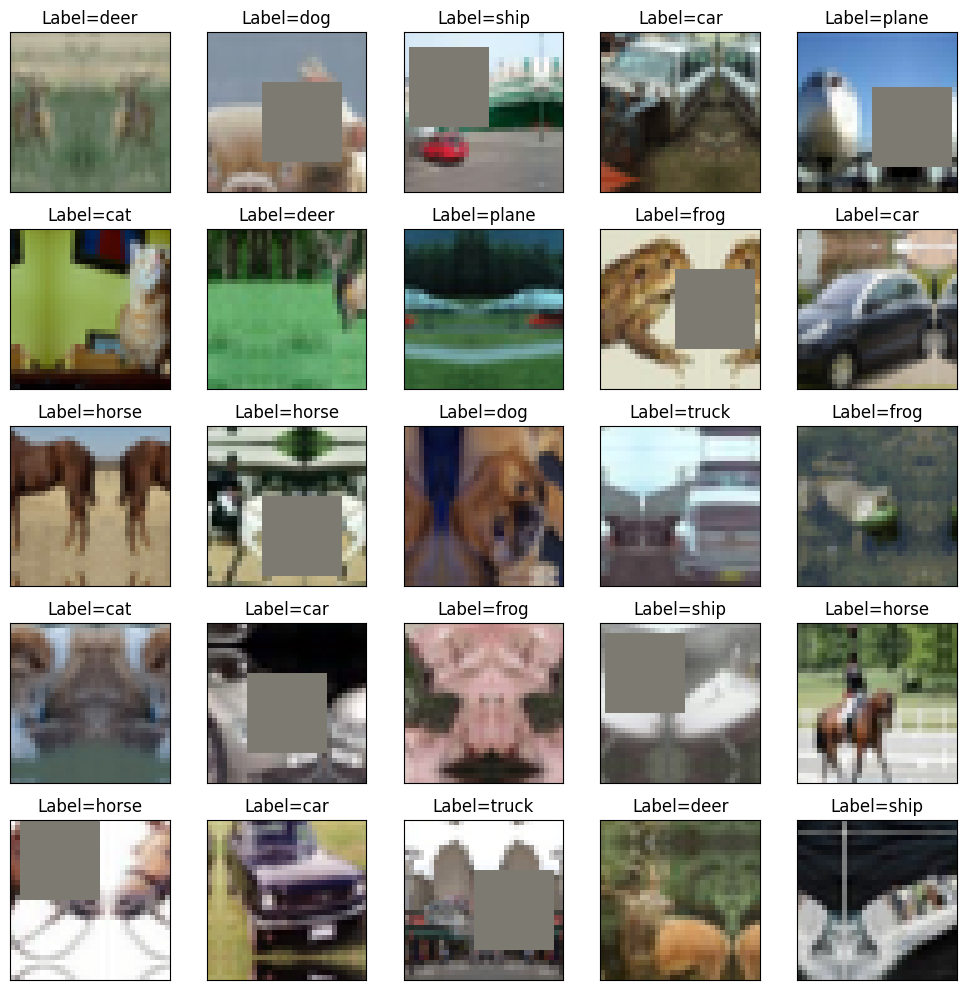

In [8]:
cifar10.sample_pictures(train_flag=True)

## Model

In [10]:
from ERA_V2.S10.custom_resnet import *

# Loading Custom Model
net = Net()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


## Model Summary

In [11]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
                 X-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

## LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.26E-03


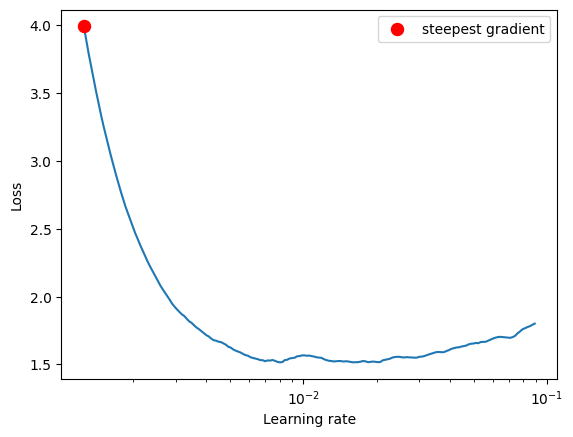

<Axes: xlabel='Learning rate', ylabel='Loss'>

In [12]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

net_exp = copy.deepcopy(net)
optimizer = torch.optim.Adam(net_exp.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=0.1, num_iter=200)
lr_finder.plot()

## Define a Loss function and optimizer

In [13]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01) #, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=0.003,
                                                steps_per_epoch=len(trainloader),
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False,
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,

## Training & Testing

Epoch: 0,Loss=1.11 Batch_id=97 Accuracy=45.78: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]


Test set: Average loss: 0.0022, Accuracy: 6151/10000 (61.51%)



Epoch: 1,Loss=0.89 Batch_id=97 Accuracy=61.03: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]


Test set: Average loss: 0.0021, Accuracy: 6329/10000 (63.29%)



Epoch: 2,Loss=0.82 Batch_id=97 Accuracy=67.62: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]


Test set: Average loss: 0.0018, Accuracy: 6911/10000 (69.11%)



Epoch: 3,Loss=0.81 Batch_id=97 Accuracy=70.94: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Test set: Average loss: 0.0016, Accuracy: 7282/10000 (72.82%)



Epoch: 4,Loss=0.76 Batch_id=97 Accuracy=72.74: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]


Test set: Average loss: 0.0013, Accuracy: 7856/10000 (78.56%)



Epoch: 5,Loss=0.59 Batch_id=97 Accuracy=76.02: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]


Test set: Average loss: 0.0013, Accuracy: 7828/10000 (78.28%)



Epoch: 6,Loss=0.65 Batch_id=97 Accuracy=78.16: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Test set: Average loss: 0.0013, Accuracy: 7868/10000 (78.68%)



Epoch: 7,Loss=0.61 Batch_id=97 Accuracy=80.60: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


Test set: Average loss: 0.0011, Accuracy: 8169/10000 (81.69%)



Epoch: 8,Loss=0.63 Batch_id=97 Accuracy=81.38: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


Test set: Average loss: 0.0012, Accuracy: 8018/10000 (80.18%)



Epoch: 9,Loss=0.44 Batch_id=97 Accuracy=83.01: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Test set: Average loss: 0.0009, Accuracy: 8540/10000 (85.40%)



Epoch: 10,Loss=0.34 Batch_id=97 Accuracy=84.51: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]


Test set: Average loss: 0.0008, Accuracy: 8583/10000 (85.83%)



Epoch: 11,Loss=0.53 Batch_id=97 Accuracy=85.60: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]


Test set: Average loss: 0.0007, Accuracy: 8750/10000 (87.50%)



Epoch: 12,Loss=0.36 Batch_id=97 Accuracy=86.48: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]


Test set: Average loss: 0.0008, Accuracy: 8748/10000 (87.48%)



Epoch: 13,Loss=0.31 Batch_id=97 Accuracy=87.12: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]


Test set: Average loss: 0.0007, Accuracy: 8868/10000 (88.68%)



Epoch: 14,Loss=0.31 Batch_id=97 Accuracy=87.96: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]


Test set: Average loss: 0.0007, Accuracy: 8872/10000 (88.72%)



Epoch: 15,Loss=0.37 Batch_id=97 Accuracy=88.67: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


Test set: Average loss: 0.0006, Accuracy: 8897/10000 (88.97%)



Epoch: 16,Loss=0.26 Batch_id=97 Accuracy=89.36: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]


Test set: Average loss: 0.0006, Accuracy: 8967/10000 (89.67%)



Epoch: 17,Loss=0.36 Batch_id=97 Accuracy=90.19: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]


Test set: Average loss: 0.0006, Accuracy: 8964/10000 (89.64%)



Epoch: 18,Loss=0.29 Batch_id=97 Accuracy=90.63: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]


Test set: Average loss: 0.0006, Accuracy: 8947/10000 (89.47%)



Epoch: 19,Loss=0.26 Batch_id=97 Accuracy=91.52: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]


Test set: Average loss: 0.0006, Accuracy: 9059/10000 (90.59%)



Epoch: 20,Loss=0.24 Batch_id=97 Accuracy=92.24: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]


Test set: Average loss: 0.0006, Accuracy: 9058/10000 (90.58%)



Epoch: 21,Loss=0.28 Batch_id=97 Accuracy=92.73: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]


Test set: Average loss: 0.0006, Accuracy: 9102/10000 (91.02%)



Epoch: 22,Loss=0.19 Batch_id=97 Accuracy=93.48: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]


Test set: Average loss: 0.0005, Accuracy: 9121/10000 (91.21%)



Epoch: 23,Loss=0.23 Batch_id=97 Accuracy=93.67: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]


Test set: Average loss: 0.0005, Accuracy: 9160/10000 (91.60%)

Finished Training


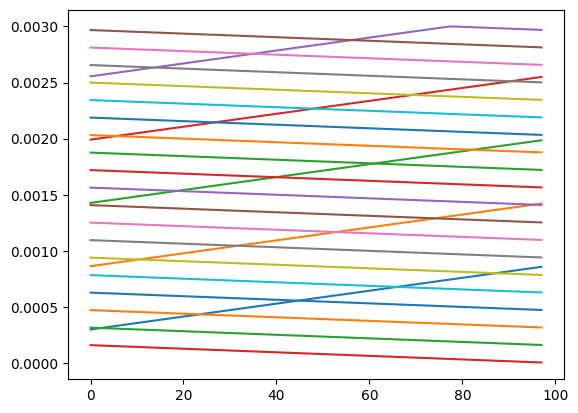

In [15]:
# Load train and test model
from ERA_V2.S10.main import *

train = train()
test = test()

EPOCHS= 24

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train.execute(net, device, trainloader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, testloader, criterion)

print('Finished Training')

## Display an image from the test set

Files already downloaded and verified


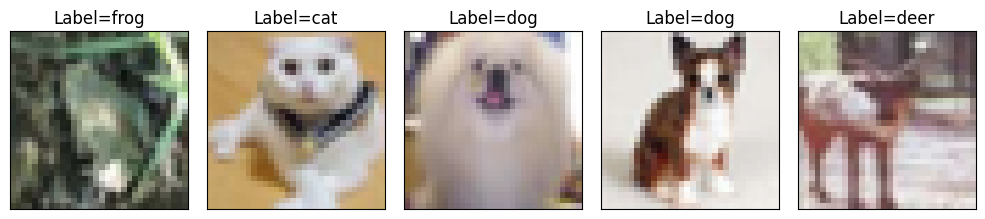

In [16]:
images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)

## Prediction of sampe test set

In [17]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:   frog   cat   dog   dog  deer


## Evaluating Training Accuracy

In [19]:
from ERA_V2.S10.evaluate import *
calAccuracy(net, trainloader, device)

Accuracy of the network on the  train images: 93.176 %%


## Evaluating Test Accuracy

In [20]:
calAccuracy(net, testloader, device)

Accuracy of the network on the  train images: 91.6 %%


## Evaluating test Accuracy over different classes

In [21]:
calClassAccuracy(net, testloader,classes, device)

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 88 %
Accuracy of   cat : 90 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


## Misclassified Images

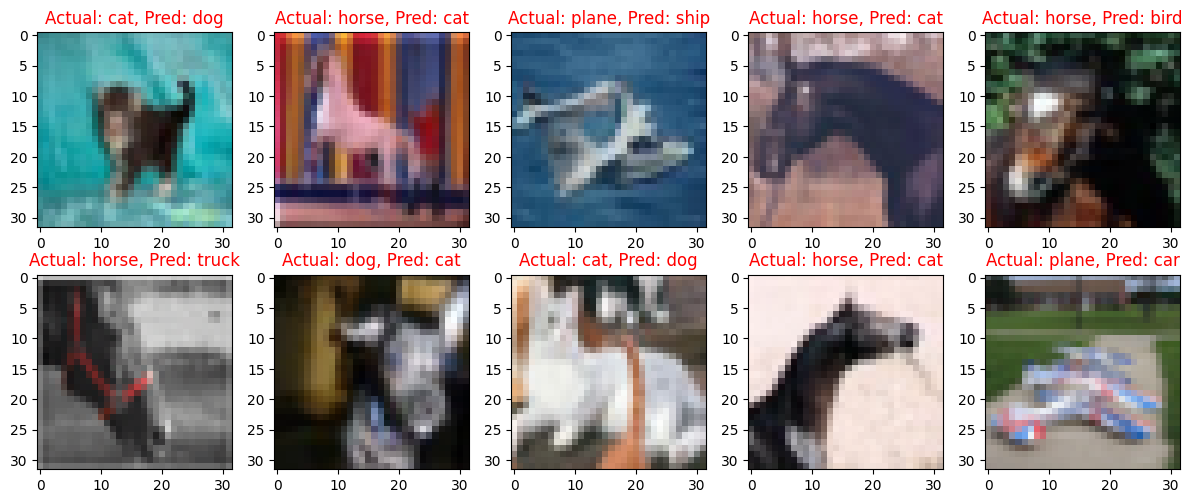

In [23]:
from ERA_V2.S10.utils import plot_misclassified_images
plot_misclassified_images(net, testloader, classes, device)